# DeepDream

TensorFlow 2.x 实现 DeepDream。

本文来自 TensorFlow 官方 Tutorials： [DeepDream](https://www.tensorflow.org/tutorials/generative/deepdream)

因为原来的教程中狗的图片看起来有点密集恐惧，引起不适，所以换了个图片；因为是 Go 语言的粉丝，所以换了一张 Go 十周年官方博客放出来的图片，我们来看看小土拨鼠们进去深度梦境是如何的。

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [ ]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

## 选择一张要处理的图片

In [ ]:
# 加载图片并存入 numpy array 中
def load_img(image_path, max_dim=None):
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# 显示图片
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

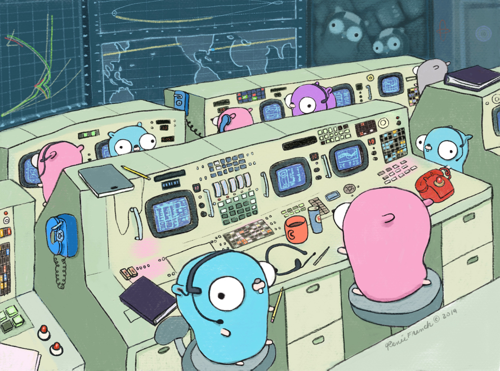

In [4]:
image_path = 'gopher10th-large.jpg'
original_img = load_img(image_path, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "https://blog.golang.org/10years/gopher10th-large.jpg">Go team</a>'))

## 准备特征提取模型

 我们使用 Keras 内置预训练好的 InceptionV3 模型。

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [ ]:
# 最大限度地激活这些层
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# 创建特征提取模型
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## 定义损失计算函数

通常 loss 是通过梯度下降希望能最小化的值。但是在 DeepDream 中，我们要通过梯度上升来最大化 loss。

In [ ]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch) # 把图像前向传入模型
  if len(layer_activations) == 1: # 将图像转换为大小为1的批处理。
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## 定义模型调用的梯度上升

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

## 先运行一个简单的 DeepDream

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

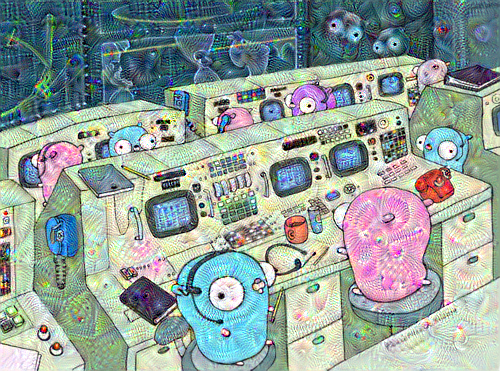

In [11]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

## 进行改进，调高尺度（八度，octave）

上面的例子有些问题：

- 输出有噪声
- 图像分辨率低
- 模式看起来好像都发生在相同的粒度上

解决所有这些问题的一种方法是在不同的图像规模上应用梯度上升。

我们定义个列表，里面包含图像的尺度，每个连续的尺度都是前一个的 OCTAVE_SCALE 倍。即，先处理小图像，然后逐渐增大图像尺寸。

那么 DeepDream 过程就是：空间处理尺寸的连续放大（八度）与放大时重新注入细节

接下来再试一遍。

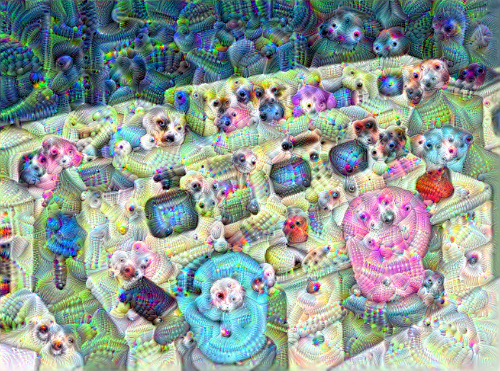

In [12]:
OCTAVE_SCALE = 1.30 # 每一个连续的尺度是前一个的 1.3 倍（放大 30%）

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

## 再次改进，拆分图像再进行八度计算

随着图像尺寸的增加，执行梯度计算所需的时间和内存也将随之增加，上面的八度实现不适用与非常大的图像。所以我们可以把图像拆分为图块并为每个图块计算梯度。

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [ ]:
def random_roll(img, maxroll):
  # 随机移动图像以避免平铺边界
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

运行最终版本的 DeepDream

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

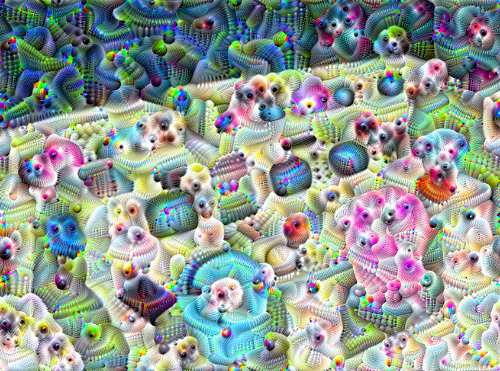

In [17]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)